<a href="https://colab.research.google.com/github/2degree/test_project2/blob/main/LSTM%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1%EC%9D%98_%EC%82%AC%EB%B3%B8(%EA%B3%BC%EC%A0%9C_%EC%B9%B4%EC%B9%B4%EC%98%A4_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15, 20)

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**설치

In [2]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import FinanceDataReader as fdr

In [4]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [5]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-07-08,58600,59300,58200,58700,15339271,0.008591
2022-07-11,59300,59600,58700,58800,13042624,0.001704
2022-07-12,58600,58700,58100,58100,9336061,-0.011905
2022-07-13,58300,58600,58000,58000,10841315,-0.001721
2022-07-14,57500,58200,57400,57500,14988231,-0.008621


**미국 주식 데이터**도 가져올 수 있습니다.

In [6]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

In [7]:
apple.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2022-07-07,146.35,143.29,146.55,143.28,65730000.0,0.0240
2022-07-08,147.04,145.26,147.55,145.00,64300000.0,0.0047
2022-07-11,144.89,145.71,146.62,143.78,60090000.0,-0.0146
2022-07-12,145.86,145.96,148.44,145.05,77270000.0,0.0067
2022-07-13,145.49,142.84,146.41,142.18,70800000.0,-0.0025


다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

In [8]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL', '2017')

In [9]:
apple.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-03,29.04,28.95,29.08,28.69,115130000.0,0.0031
2017-01-04,29.00,28.96,29.13,28.94,84470000.0,-0.0014
2017-01-05,29.15,28.98,29.22,28.95,88770000.0,0.0052
2017-01-06,29.48,29.20,29.54,29.12,127010000.0,0.0113
2017-01-09,29.75,29.49,29.86,29.48,134250000.0,0.0092


**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [10]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

In [11]:
ford.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-03-18,1.83,1.83,1.85,1.82,3770000.0,-0.0108
1980-03-19,1.85,1.85,1.86,1.83,1560000.0,0.0109
1980-03-20,1.86,1.86,1.88,1.85,1450000.0,0.0054
1980-03-21,1.78,1.78,1.85,1.76,5020000.0,-0.0430
1980-03-24,1.71,1.71,1.75,1.66,3330000.0,-0.0393


In [13]:
ford.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2019-12-23,9.44,9.50,9.57,9.40,54800000.0,-0.0042
2019-12-24,9.47,9.44,9.49,9.43,11880000.0,0.0032
2019-12-26,9.45,9.47,9.49,9.43,28980000.0,-0.0021
2019-12-27,9.36,9.45,9.46,9.35,28270000.0,-0.0095
2019-12-30,9.25,9.34,9.35,9.23,36090000.0,-0.0118


그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

In [ ]:
## 주가데이터 가져오기

**카카오**의 주가데이터를 가져와서 예측

In [15]:
# 카카오 주식코드: 035720
STOCK_CODE = '035720'

In [16]:
stock = fdr.DataReader(STOCK_CODE)

In [17]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-11-11,999,999,999,999,12,NaN
1999-11-12,1115,1115,1115,1115,140,0.116116
1999-11-15,1249,1249,1249,1249,405,0.120179
1999-11-16,1396,1396,1396,1396,214,0.117694
1999-11-17,1561,1561,1561,1561,191,0.118195


In [18]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-07-08,73900,73900,71800,71800,1418763,-0.016438
2022-07-11,71900,72800,71100,71300,979002,-0.006964
2022-07-12,70700,71000,69400,70300,1082539,-0.014025
2022-07-13,70100,72200,70100,71900,1156844,0.022760
2022-07-14,71000,73400,70400,72100,1587909,0.002782


In [19]:
stock.index

DatetimeIndex(['1999-11-11', '1999-11-12', '1999-11-15', '1999-11-16',
               '1999-11-17', '1999-11-18', '1999-11-19', '1999-11-22',
               '1999-11-23', '1999-11-24',
               ...
               '2022-07-01', '2022-07-04', '2022-07-05', '2022-07-06',
               '2022-07-07', '2022-07-08', '2022-07-11', '2022-07-12',
               '2022-07-13', '2022-07-14'],
              dtype='datetime64[ns]', name='Date', length=5597, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [21]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [22]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1999-11-11,999,999,999,999,12,NaN,1999,11,11
1999-11-12,1115,1115,1115,1115,140,0.116116,1999,11,12
1999-11-15,1249,1249,1249,1249,405,0.120179,1999,11,15
1999-11-16,1396,1396,1396,1396,214,0.117694,1999,11,16
1999-11-17,1561,1561,1561,1561,191,0.118195,1999,11,17


## 시각화

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


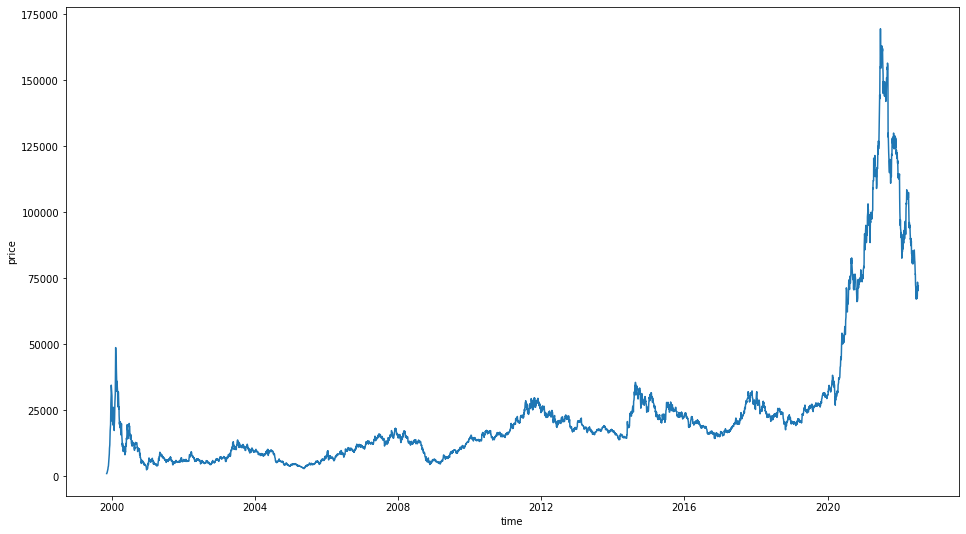

In [23]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


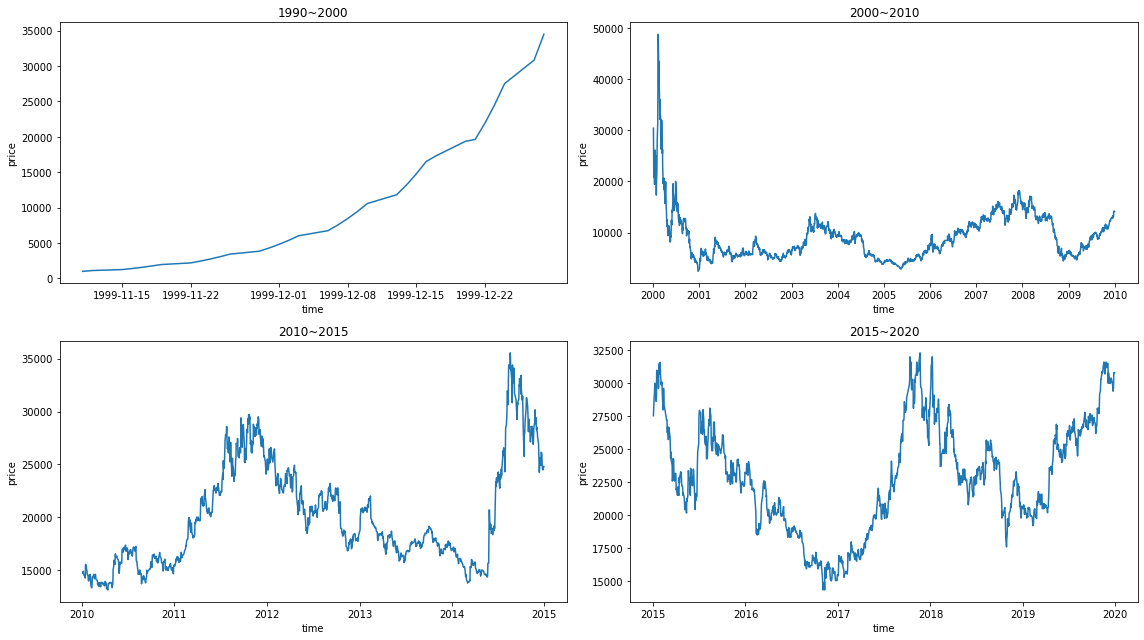

In [24]:
time_steps = [['1990', '2000'], # 특정기간을 설정하여 subplot 표현
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax) # 선형플롯
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # MinMaxScaler 인스턴스화

# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[5.80813953e-03, 5.77456647e-03, 6.20496894e-03, 0.00000000e+00,
        6.35083673e-07],
       [6.48255814e-03, 6.44508671e-03, 6.92546584e-03, 6.88423214e-04,
        7.40930952e-06],
       [7.26162791e-03, 7.21965318e-03, 7.75776398e-03, 1.48367072e-03,
        2.14340740e-05],
       ...,
       [4.11046512e-01, 4.10404624e-01, 4.31055901e-01, 4.11279458e-01,
        5.72919037e-02],
       [4.07558140e-01, 4.17341040e-01, 4.35403727e-01, 4.20774951e-01,
        6.12243947e-02],
       [4.12790698e-01, 4.24277457e-01, 4.37267081e-01, 4.21961887e-01,
        8.40379234e-02]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [26]:
df = pd.DataFrame(scaled, columns=scale_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5597 entries, 0 to 5596
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5597 non-null   float64
 1   High    5597 non-null   float64
 2   Low     5597 non-null   float64
 3   Close   5597 non-null   float64
 4   Volume  5597 non-null   float64
dtypes: float64(5)
memory usage: 218.8 KB


## train / test 분할

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [29]:
x_train.shape, y_train.shape

((4477, 4), (4477,))

In [30]:
x_test.shape, y_test.shape

((1120, 4), (1120,))

In [31]:
x_train

,Open,High,Low,Volume
0,0.005808,0.005775,0.006205,6.350837e-07
1,0.006483,0.006445,0.006925,7.409310e-06
2,0.007262,0.007220,0.007758,2.143407e-05
3,0.008116,0.008069,0.008671,1.132566e-05
4,0.009076,0.009023,0.009696,1.010842e-05
...,...,...,...,...
4472,0.161035,0.161850,0.166429,7.739796e-02
4473,0.155785,0.158364,0.163938,3.609186e-02
4474,0.157523,0.159514,0.166422,2.821063e-02
4475,0.156372,0.155468,0.160820,3.797986e-02


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [32]:
import tensorflow as tf

In [33]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [34]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [35]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [36]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [38]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [39]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [40]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    140/Unknown - 16s 7ms/step - loss: 8.4839e-05 - mse: 1.6968e-04
Epoch 1: val_loss improved from inf to 0.00035, saving model to tmp/ckeckpointer.ckpt
140/140 [==============================] - 17s 15ms/step - loss: 8.4839e-05 - mse: 1.6968e-04 - val_loss: 3.4858e-04 - val_mse: 6.9715e-04
Epoch 2/50
133/140 [===========================>..] - ETA: 0s - loss: 3.1015e-05 - mse: 6.2029e-05
Epoch 2: val_loss improved from 0.00035 to 0.00028, saving model to tmp/ckeckpointer.ckpt
140/140 [==============================] - 1s 8ms/step - loss: 3.0337e-05 - mse: 6.0675e-05 - val_loss: 2.7635e-04 - val_mse: 5.5269e-04
Epoch 3/50
138/140 [============================>.] - ETA: 0s - loss: 2.5695e-05 - mse: 5.1391e-05
Epoch 3: val_loss improved from 0.00028 to 0.00021, saving model to tmp/ckeckpointer.ckpt
140/140 [==============================] - 1s 8ms/step - loss: 2.5557e-05 - mse: 5.1115e-05 - val_loss: 2.1139e-04 - val_mse: 4.2278e-04
Epoch 4/50
137/140 [========================

저장한 ModelCheckpoint 를 로드합니다.

In [41]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [42]:
pred = model.predict(test_data)

In [43]:
pred.shape

(1100, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

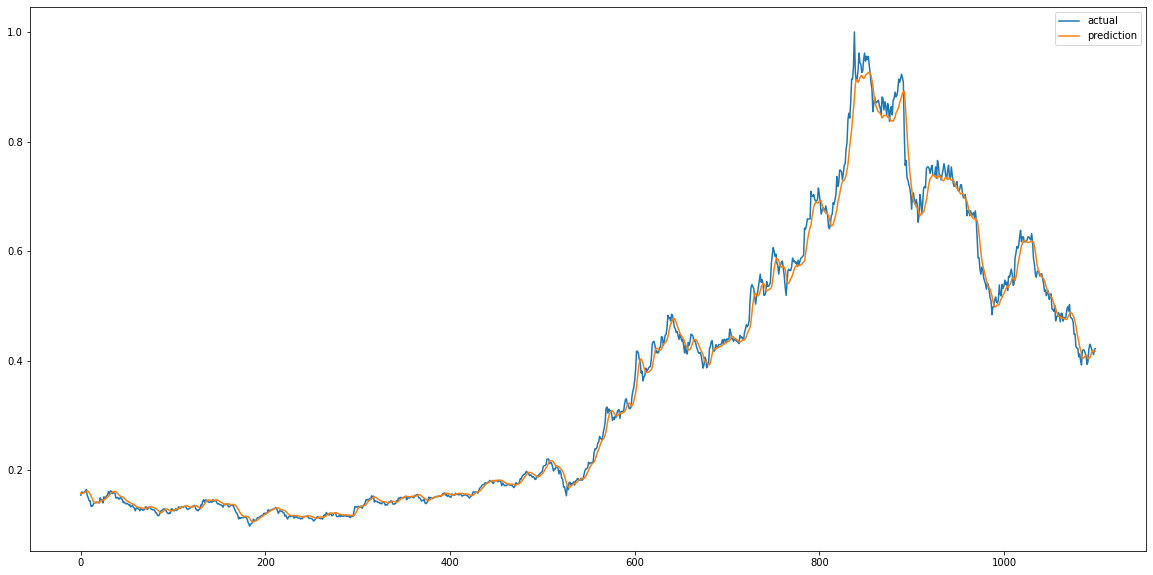

In [44]:
plt.figure(figsize=(20, 10))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()